In [1]:
import h5py
import torch
import os
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data.dataset import Dataset
import numpy as np
import setting
import time
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import ComFunction as cf
import math
import spectral
import cv2

from vit_pytorch import ViT

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type=='cuda':
#     dtype = torch.float32
#     torch.set_default_tensor_type(torch.cuda.FloatTensor)
    dtype = torch.float64
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
else:
#     dtype = torch.float32
#     torch.set_default_tensor_type(torch.FloatTensor)
    dtype = torch.float64
    torch.set_default_tensor_type(torch.DoubleTensor)
print(device.type)

cuda


In [3]:
class HyperData(Dataset):
    def __init__(self, data, labels, position, transfor):
        self.data = data
        self.transformer = transfor
        self.labels = labels
        self.position = position
        

    def __getitem__(self, index):
        img = self.data[index,:,:]
        label = self.labels[index]
        position = self.position[index,:]
        return img, label, position

    def __len__(self):
        return len(self.labels)

    def __labels__(self):
        return self.labels

In [4]:
def gain_neighborhood_band(x_train, band, band_patch, patch=5):
    nn = band_patch // 2
    pp = (patch*patch) // 2
    x_train_reshape = x_train.reshape(x_train.shape[0], patch*patch, band)
    x_train_band = np.zeros((x_train.shape[0], patch*patch*band_patch, band),dtype=float)
    # 中心区域
    x_train_band[:,nn*patch*patch:(nn+1)*patch*patch,:] = x_train_reshape
    #左边镜像
    for i in range(nn):
        if pp > 0:
            x_train_band[:,i*patch*patch:(i+1)*patch*patch,:i+1] = x_train_reshape[:,:,band-i-1:]
            x_train_band[:,i*patch*patch:(i+1)*patch*patch,i+1:] = x_train_reshape[:,:,:band-i-1]
        else:
            x_train_band[:,i:(i+1),:(nn-i)] = x_train_reshape[:,0:1,(band-nn+i):]
            x_train_band[:,i:(i+1),(nn-i):] = x_train_reshape[:,0:1,:(band-nn+i)]
    #右边镜像
    for i in range(nn):
        if pp > 0:
            x_train_band[:,(nn+i+1)*patch*patch:(nn+i+2)*patch*patch,:band-i-1] = x_train_reshape[:,:,i+1:]
            x_train_band[:,(nn+i+1)*patch*patch:(nn+i+2)*patch*patch,band-i-1:] = x_train_reshape[:,:,:i+1]
        else:
            x_train_band[:,(nn+1+i):(nn+2+i),(band-i-1):] = x_train_reshape[:,0:1,:(i+1)]
            x_train_band[:,(nn+1+i):(nn+2+i),:(band-i-1)] = x_train_reshape[:,0:1,(i+1):]
    return x_train_band

In [5]:
a=np.array([[0,0,0,],
[0.996108949416342,0.992202639810788,0.535164415960937],
[0.996108949416342,0.00781261921110857,0.980483710994125],
[0.996108949416342,0.347661554894331,0.00390630960555428],
[0.719531548027771,0.996108949416342,0.519539177538720],
[0.0117189288166629,0.109376668955520,0.941420614938582],
[0.347661554894331,0.00390630960555428,0.996108949416342],
[0.0117189288166629,0.667978942549783,0.996108949416342],
[0.0468757152666514,0.996108949416342,0.0273441672388800],
[0.671885252155337,0.683604180972000,0.328130006866560],
[0.625009536888685,0.304692149233234,0.617196917677577],
[0.597924773022049,0.677821011673152,1],
[0.234378576333257,0.355474174105440,0.437506675822080],
[0.406256198977646,0.750011444266423,0.246097505149920],
[0.542977035172045,0.269535362783246,0.179690241855497],
[0.964850843060960,0.896108949416342,0.671885252155337],
[0.992202639810788,0.996108949416342,0.0117189288166629]]
)
color_map=255*a

In [6]:
EPOCH=setting.EPOCH
BATCH_SIZE=setting.BATCH_SIZE
LR=setting.LR

In [7]:
net=ViT(
    image_size = setting.PATCH_SIZE,
    near_band = setting.band_patches,
    num_patches = setting.band,
    num_classes = setting.num_class,
    dim = 64,
    depth = 5,
    heads = 4,
    mlp_dim = 8,
    dropout = 0.1,
    emb_dropout = 0.1,
    mode = setting.mode
).to(device)

best_model_name='./model/model_best/model_time_2022_11_15_16_52.pth'
model = torch.load(best_model_name)
# model_name='.\model\model_time_2022_05_09_15_13.pth'
# model = torch.load(model_name)

net.load_state_dict(model['net'])

<All keys matched successfully>

预测6

In [8]:
no=setting.no

In [9]:
test_filename = './sample/Test_'+str(no)+'_6'+ '_'+str(setting.PATCH_SIZE)+ '_'+ str(setting.DTYPE)+'.h5'
with h5py.File(test_filename,'r') as readfile:
    test=readfile['test_patch'][:]
    test_labels=readfile['test_labels'][:]
    test_position=readfile['test_position'][:]
print('test size:', test.shape)
print('test_labels size:', test_labels.shape)
print('test_position size:', test_position.shape)


test_max=np.max(np.abs(test))
print('test max:',test_max)
# stest=stest/stest_max
print('test label name:',np.unique(test_labels))

test size: (38397, 5, 5, 204)
test_labels size: (38397,)
test_position size: (38397, 2)
test max: 0.939393937587738
test label name: [0 1]


In [10]:
test_band = gain_neighborhood_band(test, setting.band, setting.band_patches, setting.PATCH_SIZE)
print(test_band.shape)
test_band =test_band.transpose(0,2,1)
print(test_band .shape)

(38397, 25, 204)
(38397, 204, 25)


In [11]:
test_set=HyperData(test_band, test_labels, test_position,None)
testloader= Data.DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=False, num_workers=0)

In [12]:
net.eval()
predict_testlabels=[]
testlabels=[]
pre_testposition=[]
t1=time.time()
with torch.no_grad():
    for tsdata in testloader:
        tsinputs, tslabels, tsposition = tsdata
        tsinputs = tsinputs.to(device)
        tslabels = tslabels.to(device)
        tsoutputs = net(tsinputs)
        _, tspredicted = torch.max(F.softmax(tsoutputs), 1)
        predict_testlabels.extend(tspredicted)
        testlabels.extend(tslabels)
        pre_testposition.extend(tsposition)
    print('predict testing set finished')
t2=time.time()
print('predict test time:',t2-t1)
# print('predict label class name:',np.unique(predict_testlabels))

predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
testlabels=torch.tensor(testlabels,device='cpu')

oa_test, aa_test, kappa_test, acc_test=cf.eval_results_own(predict_testlabels,testlabels,2)
print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)

C:\Users\h'p\AppData\Local\Temp\ipykernel_4720\1214860408.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, tspredicted = torch.max(F.softmax(tsoutputs), 1)


predict testing set finished
predict test time: 65.67012453079224
OA_test: 0.14579264005000392 
AA_test: 0.5401512490553587 
kappa_test: 0.010316165271681492 
acc_test: [0.09312301 0.98717949]


In [13]:
print('predict label class name:',np.unique(predict_testlabels))

predict label class name: [0 1]


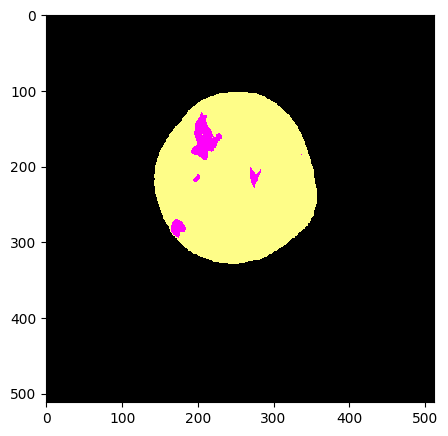

In [21]:
label_file='Label_6'
path=os.path.join(setting.test_label_path, label_file + '.png')

label_map = cv2.imread(os.path.join(setting.test_label_path, label_file + '.png'), cv2.IMREAD_GRAYSCALE)


label_image = spectral.imshow(classes = label_map,figsize =(5,10),colors=color_map)

In [22]:
[h,w]=label_map.shape
test_map=np.zeros([h,w])
pre_map=np.zeros([h,w])

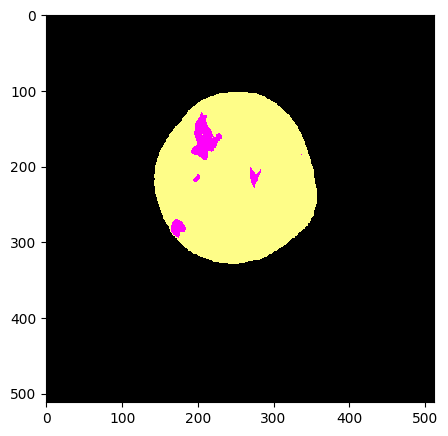

In [18]:
for i in range(len(test_labels)):
    [x,y]=test_position[i,:]
    test_map[x,y]=test_labels[i]+1
    
test_image = spectral.imshow(classes = test_map.astype(int),figsize =(5,10),colors=color_map)

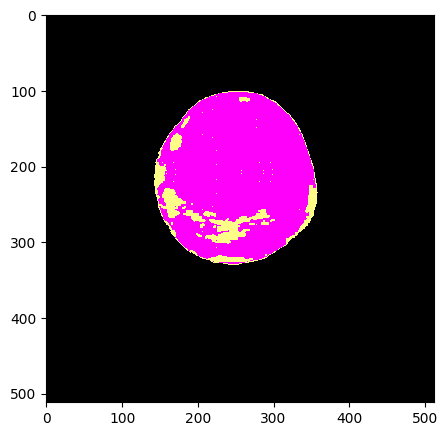

In [19]:
for i in range(len(predict_testlabels)):
    [x,y]=pre_testposition[i]
    pre_map[x,y]=predict_testlabels[i]+1
    
pre_image = spectral.imshow(classes = pre_map.astype(int),figsize =(5,10),colors=color_map)

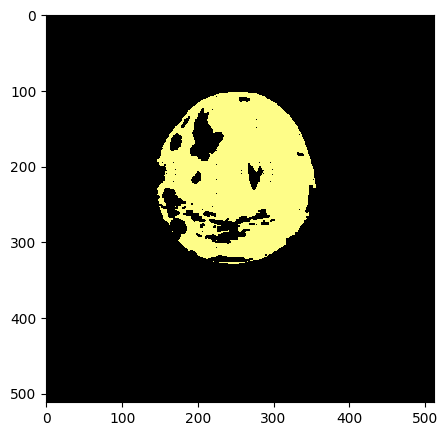

In [20]:
ERR1=np.where(pre_map!=test_map,1,0)
err_image_1 = spectral.imshow(classes = ERR1.astype(int),figsize =(5,10),colors=color_map)

预测7

In [23]:
test_filename = './sample/Test_'+str(no)+'_7'+ '_'+str(setting.PATCH_SIZE)+'_'+ str(setting.DTYPE)+'.h5'
with h5py.File(test_filename,'r') as readfile:
    test=readfile['test_patch'][:]
    test_labels=readfile['test_labels'][:]
    test_position=readfile['test_position'][:]
print('test size:', test.shape)
print('test_labels size:', test_labels.shape)
print('test_position size:', test_position.shape)


test_max=np.max(np.abs(test))
print('test max:',test_max)
# stest=stest/stest_max
print('test label name:',np.unique(test_labels))

test_band = gain_neighborhood_band(test, setting.band, setting.band_patches, setting.PATCH_SIZE)
print(test_band.shape)
test_band =test_band.transpose(0,2,1)
print(test_band .shape)

test size: (38874, 5, 5, 204)
test_labels size: (38874,)
test_position size: (38874, 2)
test max: 0.8999999761581421
test label name: [0 1]
(38874, 25, 204)
(38874, 204, 25)


In [24]:
test_set=HyperData(test_band, test_labels, test_position,None)
testloader= Data.DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=False, num_workers=0)

In [25]:
net.eval()
predict_testlabels=[]
testlabels=[]
pre_testposition=[]
t1=time.time()
with torch.no_grad():
    for tsdata in testloader:
        tsinputs, tslabels, tsposition = tsdata
        tsinputs = tsinputs.to(device)
        tslabels = tslabels.to(device)
        tsoutputs = net(tsinputs)
        _, tspredicted = torch.max(F.softmax(tsoutputs), 1)
        predict_testlabels.extend(tspredicted)
        testlabels.extend(tslabels)
        pre_testposition.extend(tsposition)
    print('predict testing set finished')
t2=time.time()
print('predict test time:',t2-t1)
# print('predict label class name:',np.unique(predict_testlabels))

predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
testlabels=torch.tensor(testlabels,device='cpu')

oa_test, aa_test, kappa_test, acc_test=cf.eval_results_own(predict_testlabels,testlabels,2)
print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)

C:\Users\h'p\AppData\Local\Temp\ipykernel_4720\1214860408.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, tspredicted = torch.max(F.softmax(tsoutputs), 1)


predict testing set finished
predict test time: 56.65235781669617
OA_test: 0.4310850439882698 
AA_test: 0.5814540824974543 
kappa_test: 0.10212982734228002 
acc_test: [0.24977875 0.91312941]


In [26]:
print('predict label class name:',np.unique(predict_testlabels))

predict label class name: [0 1]


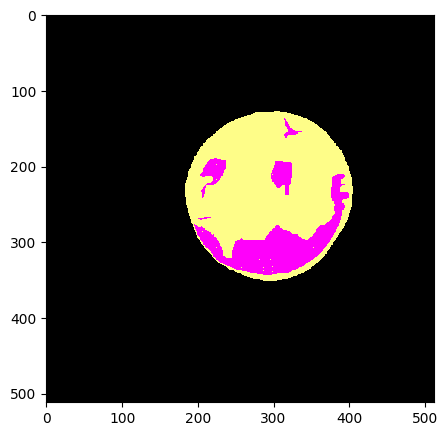

In [27]:
label_file='Label_7'
label_map = cv2.imread(os.path.join(setting.test_label_path, label_file + '.png'), cv2.IMREAD_GRAYSCALE)
label_image = spectral.imshow(classes = label_map,figsize =(5,10),colors=color_map)

In [28]:
[h,w]=label_map.shape
test_map=np.zeros([h,w])
pre_map=np.zeros([h,w])

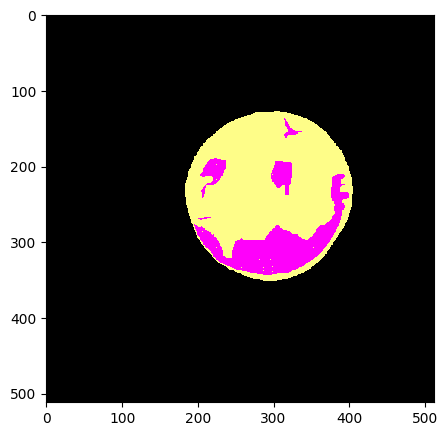

In [29]:
for i in range(len(test_labels)):
    [x,y]=test_position[i,:]
    test_map[x,y]=test_labels[i]+1
    
test_image = spectral.imshow(classes = test_map.astype(int),figsize =(5,10),colors=color_map)

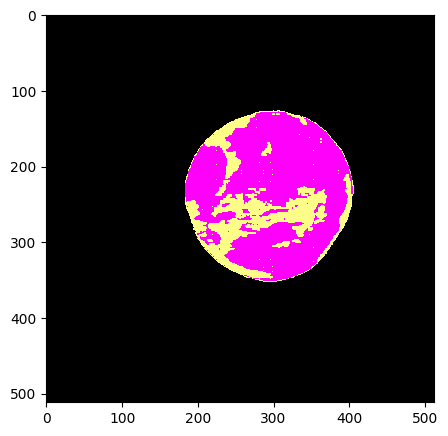

In [30]:
for i in range(len(predict_testlabels)):
    [x,y]=pre_testposition[i]
    pre_map[x,y]=predict_testlabels[i]+1
    
pre_image = spectral.imshow(classes = pre_map.astype(int),figsize =(5,10),colors=color_map)

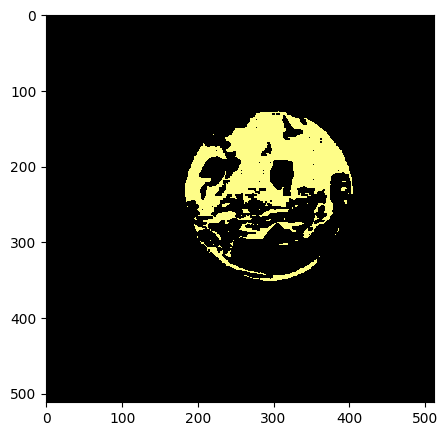

In [31]:
ERR1=np.where(pre_map!=test_map,1,0)
err_image_1 = spectral.imshow(classes = ERR1.astype(int),figsize =(5,10),colors=color_map)

预测8

In [32]:
test_filename = './sample/Test_'+str(no)+'_8'+ '_'+str(setting.PATCH_SIZE)+'_'+ str(setting.DTYPE)+'.h5'
with h5py.File(test_filename,'r') as readfile:
    test=readfile['test_patch'][:]
    test_labels=readfile['test_labels'][:]
    test_position=readfile['test_position'][:]
print('test size:', test.shape)
print('test_labels size:', test_labels.shape)
print('test_position size:', test_position.shape)


test_max=np.max(np.abs(test))
print('test max:',test_max)
# stest=stest/stest_max
print('test label name:',np.unique(test_labels))

test_band = gain_neighborhood_band(test, setting.band, setting.band_patches, setting.PATCH_SIZE)
print(test_band.shape)
test_band =test_band.transpose(0,2,1)
print(test_band .shape)

test size: (44917, 5, 5, 204)
test_labels size: (44917,)
test_position size: (44917, 2)
test max: 0.9090909361839294
test label name: [0 1]
(44917, 25, 204)
(44917, 204, 25)


In [33]:
test_set=HyperData(test_band, test_labels, test_position,None)
testloader= Data.DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=False, num_workers=0)

In [34]:
net.eval()
predict_testlabels=[]
testlabels=[]
pre_testposition=[]
t1=time.time()
with torch.no_grad():
    for tsdata in testloader:
        tsinputs, tslabels, tsposition = tsdata
        tsinputs = tsinputs.to(device)
        tslabels = tslabels.to(device)
        tsoutputs = net(tsinputs)
        _, tspredicted = torch.max(F.softmax(tsoutputs), 1)
        predict_testlabels.extend(tspredicted)
        testlabels.extend(tslabels)
        pre_testposition.extend(tsposition)
    print('predict testing set finished')
t2=time.time()
print('predict test time:',t2-t1)
# print('predict label class name:',np.unique(predict_testlabels))

predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
testlabels=torch.tensor(testlabels,device='cpu')

oa_test, aa_test, kappa_test, acc_test=cf.eval_results_own(predict_testlabels,testlabels,2)
print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)

C:\Users\h'p\AppData\Local\Temp\ipykernel_4720\1214860408.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, tspredicted = torch.max(F.softmax(tsoutputs), 1)


predict testing set finished
predict test time: 65.3778657913208
OA_test: 0.14800632277311485 
AA_test: 0.5346102395719324 
kappa_test: 0.012433276607441172 
acc_test: [0.06922048 1.        ]


In [35]:
print('predict label class name:',np.unique(predict_testlabels))

predict label class name: [0 1]


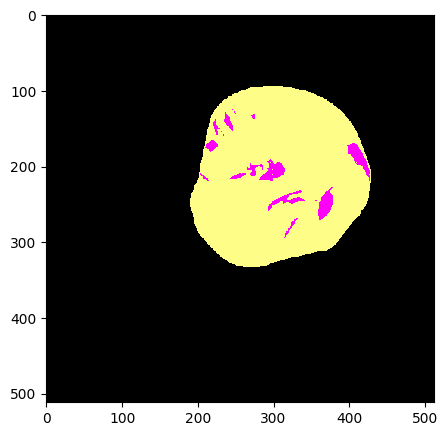

In [36]:
label_file='Label_8'
label_map = cv2.imread(os.path.join(setting.test_label_path, label_file + '.png'), cv2.IMREAD_GRAYSCALE)
label_image = spectral.imshow(classes = label_map,figsize =(5,10),colors=color_map)

In [37]:
[h,w]=label_map.shape
test_map=np.zeros([h,w])
pre_map=np.zeros([h,w])

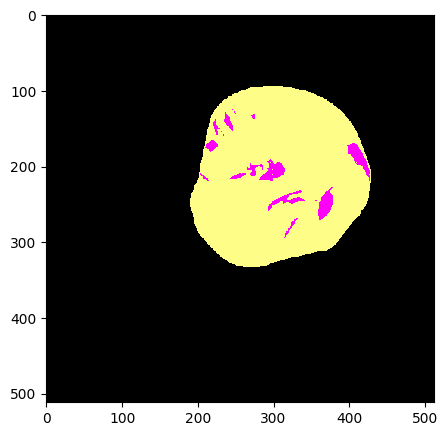

In [38]:
for i in range(len(test_labels)):
    [x,y]=test_position[i,:]
    test_map[x,y]=test_labels[i]+1
    
test_image = spectral.imshow(classes = test_map.astype(int),figsize =(5,10),colors=color_map)

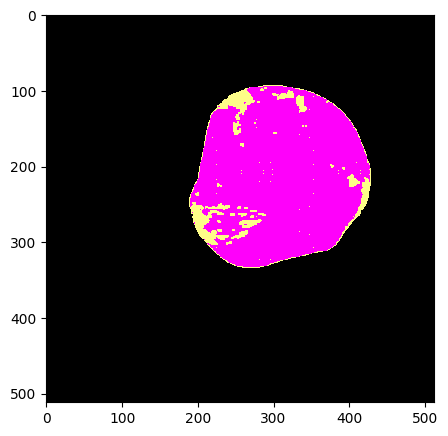

In [39]:
for i in range(len(predict_testlabels)):
    [x,y]=pre_testposition[i]
    pre_map[x,y]=predict_testlabels[i]+1
    
pre_image = spectral.imshow(classes = pre_map.astype(int),figsize =(5,10),colors=color_map)

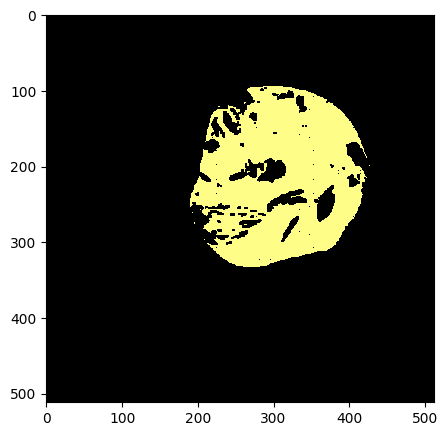

In [40]:
ERR1=np.where(pre_map!=test_map,1,0)
err_image_1 = spectral.imshow(classes = ERR1.astype(int),figsize =(5,10),colors=color_map)

预测9

In [41]:
test_filename = './sample/Test_'+str(no)+'_9'+ '_'+str(setting.PATCH_SIZE)+'_'+ str(setting.DTYPE)+'.h5'
with h5py.File(test_filename,'r') as readfile:
    test=readfile['test_patch'][:]
    test_labels=readfile['test_labels'][:]
    test_position=readfile['test_position'][:]
print('test size:', test.shape)
print('test_labels size:', test_labels.shape)
print('test_position size:', test_position.shape)


test_max=np.max(np.abs(test))
print('test max:',test_max)
# stest=stest/stest_max
print('test label name:',np.unique(test_labels))

test_band = gain_neighborhood_band(test, setting.band, setting.band_patches, setting.PATCH_SIZE)
print(test_band.shape)
test_band =test_band.transpose(0,2,1)
print(test_band .shape)

test size: (45949, 5, 5, 204)
test_labels size: (45949,)
test_position size: (45949, 2)
test max: 0.9189189076423645
test label name: [0 1]
(45949, 25, 204)
(45949, 204, 25)


In [42]:
test_set=HyperData(test_band, test_labels, test_position,None)
testloader= Data.DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=False, num_workers=0)

In [43]:
net.eval()
predict_testlabels=[]
testlabels=[]
pre_testposition=[]
t1=time.time()
with torch.no_grad():
    for tsdata in testloader:
        tsinputs, tslabels, tsposition = tsdata
        tsinputs = tsinputs.to(device)
        tslabels = tslabels.to(device)
        tsoutputs = net(tsinputs)
        _, tspredicted = torch.max(F.softmax(tsoutputs), 1)
        predict_testlabels.extend(tspredicted)
        testlabels.extend(tslabels)
        pre_testposition.extend(tsposition)
    print('predict testing set finished')
t2=time.time()
print('predict test time:',t2-t1)
# print('predict label class name:',np.unique(predict_testlabels))

predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
testlabels=torch.tensor(testlabels,device='cpu')

oa_test, aa_test, kappa_test, acc_test=cf.eval_results_own(predict_testlabels,testlabels,2)
print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)

C:\Users\h'p\AppData\Local\Temp\ipykernel_4720\1214860408.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, tspredicted = torch.max(F.softmax(tsoutputs), 1)


predict testing set finished
predict test time: 67.37961292266846
OA_test: 0.1608087227143137 
AA_test: 0.5044436938382686 
kappa_test: 0.0024672513932000218 
acc_test: [0.03371408 0.9751733 ]


In [44]:
print('predict label class name:',np.unique(predict_testlabels))

predict label class name: [0 1]


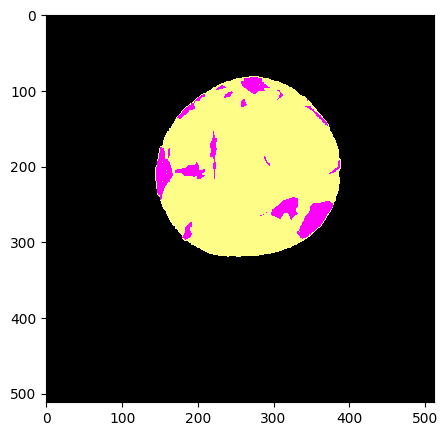

In [45]:
label_file='Label_9'
label_map = cv2.imread(os.path.join(setting.test_label_path, label_file + '.png'), cv2.IMREAD_GRAYSCALE)
label_image = spectral.imshow(classes = label_map,figsize =(5,10),colors=color_map)

In [46]:
[h,w]=label_map.shape
test_map=np.zeros([h,w])
pre_map=np.zeros([h,w])

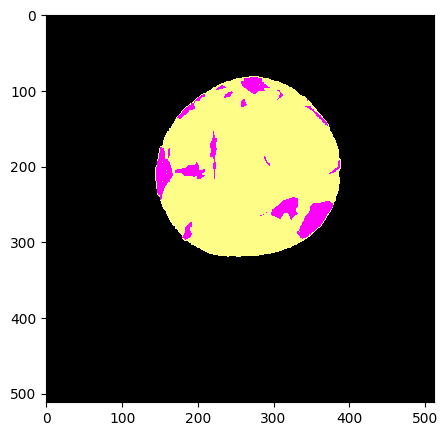

In [47]:
for i in range(len(test_labels)):
    [x,y]=test_position[i,:]
    test_map[x,y]=test_labels[i]+1
    
test_image = spectral.imshow(classes = test_map.astype(int),figsize =(5,10),colors=color_map)

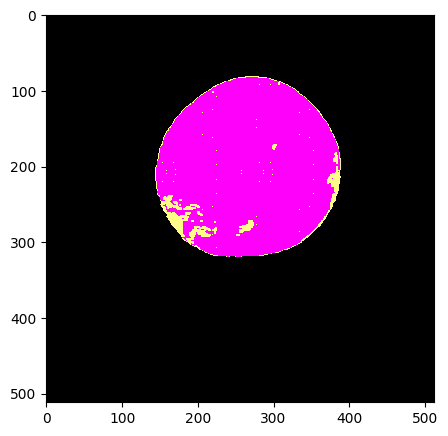

In [48]:
for i in range(len(predict_testlabels)):
    [x,y]=pre_testposition[i]
    pre_map[x,y]=predict_testlabels[i]+1
    
pre_image = spectral.imshow(classes = pre_map.astype(int),figsize =(5,10),colors=color_map)

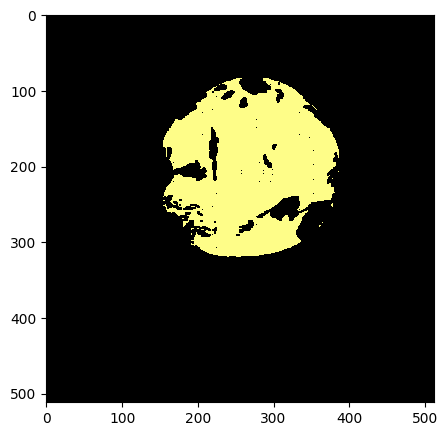

In [49]:
ERR1=np.where(pre_map!=test_map,1,0)
err_image_1 = spectral.imshow(classes = ERR1.astype(int),figsize =(5,10),colors=color_map)

预测10

In [50]:
test_filename = './sample/Test_'+str(no)+'_10'+ '_'+str(setting.PATCH_SIZE)+'_'+ str(setting.DTYPE)+'.h5'
with h5py.File(test_filename,'r') as readfile:
    test=readfile['test_patch'][:]
    test_labels=readfile['test_labels'][:]
    test_position=readfile['test_position'][:]
print('test size:', test.shape)
print('test_labels size:', test_labels.shape)
print('test_position size:', test_position.shape)


test_max=np.max(np.abs(test))
print('test max:',test_max)
# stest=stest/stest_max
print('test label name:',np.unique(test_labels))

test_band = gain_neighborhood_band(test, setting.band, setting.band_patches, setting.PATCH_SIZE)
print(test_band.shape)
test_band =test_band.transpose(0,2,1)
print(test_band .shape)

test size: (39990, 5, 5, 204)
test_labels size: (39990,)
test_position size: (39990, 2)
test max: 0.9189189076423645
test label name: [0 1]
(39990, 25, 204)
(39990, 204, 25)


In [51]:
test_set=HyperData(test_band, test_labels, test_position,None)
testloader= Data.DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=False, num_workers=0)

In [52]:
net.eval()
predict_testlabels=[]
testlabels=[]
pre_testposition=[]
t1=time.time()
with torch.no_grad():
    for tsdata in testloader:
        tsinputs, tslabels, tsposition = tsdata
        tsinputs = tsinputs.to(device)
        tslabels = tslabels.to(device)
        tsoutputs = net(tsinputs)
        _, tspredicted = torch.max(F.softmax(tsoutputs), 1)
        predict_testlabels.extend(tspredicted)
        testlabels.extend(tslabels)
        pre_testposition.extend(tsposition)
    print('predict testing set finished')
t2=time.time()
print('predict test time:',t2-t1)
# print('predict label class name:',np.unique(predict_testlabels))

predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
testlabels=torch.tensor(testlabels,device='cpu')

oa_test, aa_test, kappa_test, acc_test=cf.eval_results_own(predict_testlabels,testlabels,2)
print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)

C:\Users\h'p\AppData\Local\Temp\ipykernel_4720\1214860408.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, tspredicted = torch.max(F.softmax(tsoutputs), 1)


predict testing set finished
predict test time: 58.12968969345093
OA_test: 0.2889472368092023 
AA_test: 0.5504506988986733 
kappa_test: 0.02378060384438339 
acc_test: [0.22774739 0.87315401]


In [53]:
print('predict label class name:',np.unique(predict_testlabels))

predict label class name: [0 1]


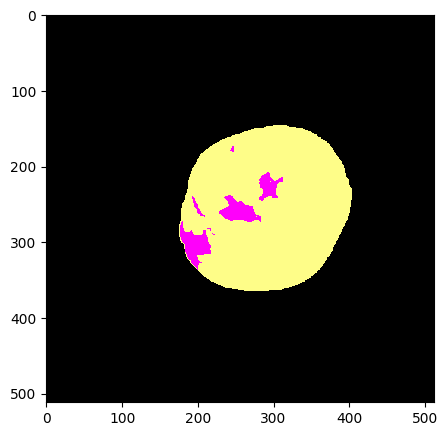

In [54]:
label_file='Label_10'
label_map = cv2.imread(os.path.join(setting.test_label_path, label_file + '.png'), cv2.IMREAD_GRAYSCALE)
label_image = spectral.imshow(classes = label_map,figsize =(5,10),colors=color_map)

In [55]:
[h,w]=label_map.shape
test_map=np.zeros([h,w])
pre_map=np.zeros([h,w])

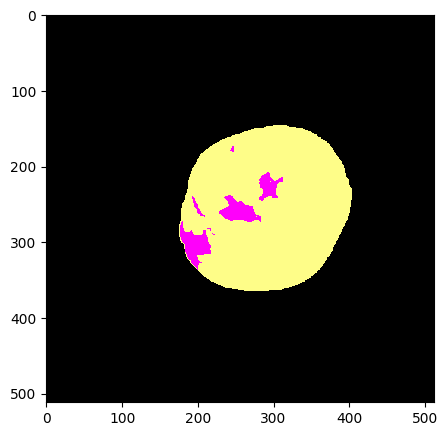

In [56]:
for i in range(len(test_labels)):
    [x,y]=test_position[i,:]
    test_map[x,y]=test_labels[i]+1
    
test_image = spectral.imshow(classes = test_map.astype(int),figsize =(5,10),colors=color_map)

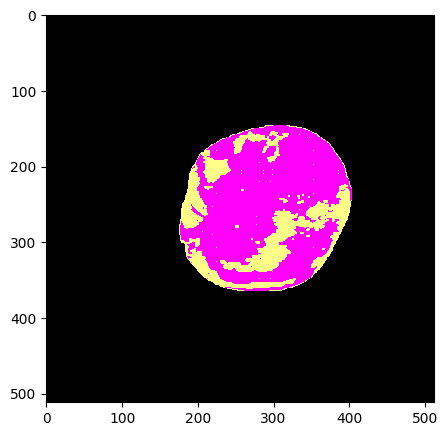

In [57]:
for i in range(len(predict_testlabels)):
    [x,y]=pre_testposition[i]
    pre_map[x,y]=predict_testlabels[i]+1
    
pre_image = spectral.imshow(classes = pre_map.astype(int),figsize =(5,10),colors=color_map)

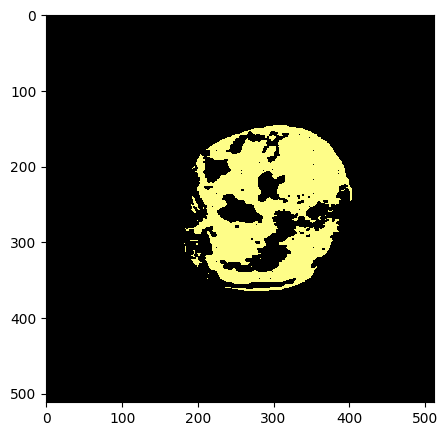

In [58]:
ERR1=np.where(pre_map!=test_map,1,0)
err_image_1 = spectral.imshow(classes = ERR1.astype(int),figsize =(5,10),colors=color_map)